# I) Introduction and Motivation

Welcome to Fredernick Lindemeyer's Project! Our focus revolves around exploring the data generated from the Muse Headband, and check if the Muse Headband is able to detect whether or not a person is "intoxicated" on nicotine.

We decided to focus on nicotine consumption based on a few factors:
* The Muse Headband is designed to detect meditative states. Since nicotine is a stimulant, we hypothesize that nicotine intoxication will cause an increase in higher cognitive brain-waves associable to a non-meditative state, hence possibly detectable.
* The literature is uncertain. There are existing contradictory findings on the impact of nicotine on brain waves. Specifically, some studies that show an increase in Alpha Frequency while others demonstrate a decrease in Alpha Frequency during periods of nicotine intoxication. As such, we believe the findings in the analysis can present a clearer picture of the conflicting literature.

# II) Related Works
Not all of our research is derivable from peer-reviewed literature. We shall list all resources used, seperated by category with each including a summary, and our insights.

## Muse Headset
The model we used was the 2014 edition Muse Headband. According to the advertisement and review, it has sampling rate is >220Hz. Since alpha waves occilate around 8-12 Hz, this well satisfies the Nyquist Theorem. 

The Muse Headband allows four different types of return values: absolute power bands, raw eeg, discrete frequency, and spectrogram. It comes with four sensors affliated with the regions TP9, AF7, AF8, and TP10.

For this project, we plan on using the raw EEG as the training data for the EEGNet, and the absolute power band data on the logistic regression classifier.

The sources we used assisted us with troubleshooting the Muse, in addition to understanding the data produced by the Muse.

#### Sources Used
* https://mind-monitor.com/FAQ.php
* https://mind-monitor.com/Technical_Manual.php
* https://web.archive.org/web/20181105231756/http://developer.choosemuse.com/tools/available-data
* Krigolson OE, Williams CC, Norton A, Hassall CD, Colino FL. Choosing MUSE: Validation of a Low-Cost, Portable EEG System for ERP Research. Front Neurosci. 2017;11:109. Published 2017 Mar 10. doi:10.3389/fnins.2017.00109

## Nicotine and Brain Waves
As previously mentioned, there are conflicting finding in the literature about the impact it has on the Alpha Frequency. Specifically We're refering to Kang et al. 2015, *The Effect of Smoking on Brain Wave Activity in Middle-Aged Men Measured by Electrocorticography*, which finds a decrease in Alpha frequency after smoking and Domina et al. 2009, *Tobacco Smoking Produces Widespread Dominant Brain Wave Alpha Frequency Increases*, which finds an increase in alpha wave frequency. As such, it is difficult to draw a conclusion based on the existing liturature of what to expect on the Alpha frequency after smoking.

We did draw inspiration from Kang's study on their data collection methodology and did something similar, where we had participants smoke, and then take the EEG within 5 minutes of completion. In addition, Kang's study also described nicotines half-life of two hours, which is useful information to take into account since we know post sobriety periods can be effected.

For research on brain waves and BCI's, a majority of our research and background comes from this course. A few examples of conceptual understandings include description of the brain frequencies, existing technologies, and sensor placements.

#### Sources Used
* Kang SH, Kim JH, Kim IK, So WY, Sung DJ. The Effect of Smoking on Brain Wave Activity in Middle-Aged Men Measured by Electrocorticography. Iran J Public Health. 2015;44(9):1288-1290. 
* Domino EF, Ni L, Thompson M, et al. Tobacco smoking produces widespread dominant brain wave alpha frequency increases. Int J Psychophysiol. 2009;74(3):192-198. doi:10.1016/j.ijpsycho.2009.08.011
* Nicolas-Alonso, L. F., & Gomez-Gil, J. (2012). Brain computer interfaces, a review. Sensors (Basel, Switzerland), 12(2), 1211–1279. https://doi.org/10.3390/s120201211

## Modeling and Analytics
A majority of the analytic concepts can be comprehended through the *Elements of Statistical Learning* and *Introduction to Statistical Learning* textbook. The main inspirations taken from them is the contextual understanding of the weights and models. 

#### Sources Used
* Hastie, T., Hastie, T., Tibshirani, R., & Friedman, J. H. (2001). The elements of statistical learning: Data mining, inference, and prediction. New York: Springer.
* Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani. An Introduction to Statistical Learning : with Applications in R. New York :Springer, 2013.

## Misc.
We copied some code and files such as the EEGNet. If we did so, the code description or comment should contain the source of where we copied the code from.

# III) Methods
## Experimentation Setup
Our experimentation was not consistent for each of the four sessions that were hosted. The experimentation evolved as we progressed, solving some potential issues and mainly because we were not able to detect any signal. We kept some key elements that were constant throughout each session, where there was a period of sobriety, and a period of intoxication. We'll go into further detail when we talk about the session information later on in this report.

We had a single test subject, Frederick, and he collected the data on himself. 

It should be noted that we will not be taking into account external factors such as the time of day, amount of nicotine smoked, and other metadata such as the accelerometer on the headband, all of which were not consistent through each of the sessions. This of course, decreases the data quality, but since we were not able to find signal in any of the sessions, this should not be an issue.

## Data
#### Data Cleaning
The Muse has a feature where the data collected should be cleaned for you. The Muse is able to detect blinks, and sudden shifts and automatically returns a null value when it does. This means that the data does not require filtering.

#### Data Description

The first thing to note, is what the descriptions of each of the data values indicate based on [Mind Monitor](https://mind-monitor.com/FAQ.php). For more detail check [here](https://mind-monitor.com/Technical_Manual.php):

| Column(s) | Description | Range/Units |
|-|-|-|
| TimeStamp | Date and Time | Year-Month-Day Hour:Minute:Second.Microsecond |
| Delta_{TP9,AF7,AF8,TP10} | Delta brainwaves, for each of the four sensors | Bels |
| Theta_{TP9,AF7,AF8,TP10} | Theta brainwaves, for each of the four sensors | Bels |
| Alpha_{TP9,AF7,AF8,TP10} | Alpha brainwaves, for each of the four sensors | Bels |
| Beta_{TP9,AF7,AF8,TP10} | Beta brainwaves, for each of the four sensors | Bels |
| Gamma_{TP9,AF7,AF8,TP10} | Gamma brainwaves, for each of the four sensors | Bels |
| RAW_{TP9,AF7,AF8,TP10} | RAW brainwaves, for each of the four sensors | 0.0 - 1682.815 uV |
| Accelerometer_{X,Y,Z} |  	Gravity. X = tilt up/down, Y = tilt left/right, Z = vertical up/down | g {-2:+2} |
| HeadBandOn | Basic data quality indicator: if the headband is on the head | 1=True, 0=False |
| HSI_{TP9,AF7,AF8,TP10} | Data quality, for each of the four sensors (HSI=Horse Shoe Indicator) | 1=True, 0=False |
| Battery | Battery charge percentage | %/100 |
| Elements | Data markers such as Blink, Jaw_Clench, or numbered markers | |

Notes:
* Sensor Location
  * AF7: Left Forehead (dependent on headsize)
  * AF8: Right Forehead (dependent on headsize)
  * TP9: Left Ear
  * TP10: Right Ear
* Abolute info
  * frequency spectrum
    * Delta: 1-4Hz
    * Theta: 4-8Hz
    * **Alpha**: 7.5-13Hz
    * Beta: 13-30Hz
    * Gamma: 30-44Hz
  * absolute band power: based on the **logarithm** of the power spectral density of EEG data for each channel
    * layman explanation: bigger the number, the more brain wave frequency collected in that region
  * normed to {-1,+1}

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn import linear_model
import os
import torch
import torch.nn as nn

In [2]:
# Data File Paths
session_one_fp = os.path.join("data","session_one","mindMonitor_2021-02-10--09-18-15.csv")
session_two_fp = os.path.join("data","session_two","mindMonitor_2021-02-24--07-21-47.csv")
session_three_fp = os.path.join("data","session_three","mindMonitor_2021-03-03--12-17-29.csv")
session_four_fp = os.path.join("data","session_four","_2021-03-10--03-38-49.csv")

# Selections
sensors = ["AF7", "AF8", "TP9", "TP10"]
waves = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
AF7, AF8, TP9, TP10 = [[f"{wave}_{sensor}" for wave in waves] for sensor in sensors]
DELTA, THETA, ALPHA, BETA, GAMMA = [[f"{wave}_{sensor}" for sensor in sensors] for wave in waves]

BATCH = 5 # for smoothing

# Visual Colorations
reg = "blue" 
intoxC = "red"
soberC = "green"
brainWaveC = "black"
postIntoxC = "yellow"

# Helper Functions
def moving_avg(arr:list, n:int) -> np.array:
    """
    @param arr - list of floats and ints to use moving avg on
    @param n - batch size to convert to mean
    returns a list of moving mean from arr with n-size batches
    """
    return np.array([np.mean(arr[i:i+n]) for i in range(len(arr) - n)])

def get_regression(period:list,wave_data:np.array) -> (float, float):
    """
    @param period - two dimensional array containing information on (start of period, end of period) within wave_data
    @param data - corresponds to brain wave information
    returns the linear regression plot data given training data
    """
    y = wave_data[period[0]:period[1]]
    X = np.arange(len(y)).reshape(-1, 1)
    mdl = linear_model.LinearRegression()
    mdl.fit(X,y)
    m,b = mdl.coef_[0], mdl.intercept_
    return [period[0], period[1]], [b + m * 0, b + m * len(y)]

# PLOTS
def brainwave_abs_plot(session:pd.DataFrame, titleName:str, periods:list, includeEndReg:bool=True, BATCH:int=BATCH):
    """
    Creates a plot for the absolute alpha waves
    @param session: pandas dataframe of the muse dataset
    @param titleName: title of the plot
    @param periods: 2d list of the (color, label, and the timespan for the background
    @param includeEndReg: if true, show the regression of both intox and post-intox
    @param BATCH: size of moving average
    """
    # Coefficient Visualization
    fig, ax = plt.subplots(4, 1, figsize=(15, 10))
    for i, s in enumerate(ALPHA):
        vals = moving_avg(session[s],BATCH)

        # Brain Waves
        ax[i].plot(vals, color=brainWaveC, label="Absolute Band Power")
        ax[i].set_title(sensors[i])
        ax[i].set_yticks([])
        ax[i].set_xticks([])

        for color, label, timespan in periods:
            # Background
            ax[i].axvspan(timespan[0], timespan[1], facecolor=color, alpha=0.2, label=label)
            # Stepwise TimeSeries Linear Regression
            x, y = get_regression(timespan, vals)
            ax[i].plot(x, y, color=reg, label="Regression")
        # Time series regression, nonsober
        if includeEndReg:
            x, y = get_regression([periods[-2][-1][0], periods[-1][-1][1]], vals)
            ax[i].plot(x, y, color="red", label="Intox/Post-Intox Reg")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.1,4.5))
    plt.suptitle(titleName)
    plt.show()
    
def brainwave_nonalpha_plot(session:pd.DataFrame, titleName:str, periods: list):
    """
    Creates a plot for the absolute non-alpha waves
    @param session: pandas dataframe of the muse dataset
    @param titleName: title of the plot
    @param periods: 2d list of the (color, label, and the timespan for the background
    """
    nonalphas = [DELTA, THETA, BETA, GAMMA]
    titles = ["Delta", "Theta", "Beta", "Gamma"]
    fig, ax = plt.subplots(4, 1, figsize=(15, 10))
    colors = ["red", "blue", "green", "brown"]

    for i, nonalpha in enumerate(nonalphas):
        # Visualization
        for j, s in enumerate(nonalpha):
            vals = moving_avg(session[s],BATCH)

            # Stepwise TimeSeries Linear Regression
            for color, label, timespan in periods:
                x, y = get_regression(timespan, vals)
                ax[i].plot(x, y, label=sensors[j], c=colors[j])
            # Brain Waves
            ax[i].plot(vals, alpha=.3, c=colors[j])
        # Background
        for color, label, timespan in periods:
            ax[i].axvspan(timespan[0], timespan[1], facecolor=color, alpha=0.2, label=label)

        ax[i].set_title(titles[i])
        ax[i].set_yticks([])
        ax[i].set_xticks([])
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.1,4.5))
    plt.suptitle(titleName)
    plt.show()    
    
def brainwave_rel_plot(session:pd.DataFrame, titleName:str, periods: list, includeEndReg:bool=True,BATCH:int=BATCH):
    """
    Creates a plot for the relative alpha waves
    @param session: pandas dataframe of the muse dataset
    @param titleName: title of the plot
    @param periods: 2d list of the (color, label, and the timespan for the background
    @param includeEndReg: if true, show the regression of both intox and post-intox
    """
    fig, ax = plt.subplots(4,1,figsize=(15,10))
    for i, sensor_names in enumerate([AF7, AF8, TP9, TP10]):
        alpha = session[sensor_names].loc[:, f"Alpha_{sensors[i]}"] ** 10
        nonalphas = (session[sensor_names] ** 10).sum(axis=1)

        relative_alpha = alpha / nonalphas
        vals = moving_avg(relative_alpha, BATCH)
        ax[i].plot(vals, color=brainWaveC, label="Relative Band Power")

        ax[i].set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_title(sensors[i])
        
        for color, label, timespan in periods:
            # Background
            ax[i].axvspan(timespan[0], timespan[1], facecolor=color, alpha=0.2, label=label)
            # Stepwise TimeSeries Linear Regression
            x, y = get_regression(timespan, vals)
            ax[i].plot(x, y, color=reg, label="Regression")
                # Time series regression, nonsober
        if includeEndReg:
            x, y = get_regression([periods[-2][-1][0], periods[-1][-1][1]], vals)
            ax[i].plot(x, y, color="red", label="Intox/Post-Intox Reg")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.1,4.5))
    plt.suptitle(titleName)
    plt.show()

## Analytics
We set a smoothing factor, defined by a moving average of 5. This is an arbitrary choice, where its small to cover periods of time when there isn't any information (due to movements and blinking), and not too big, where a lot of information is lost.

#### Session One
|time|action|
|-|-|
|9:20| vape hit|
|9:21| vape hit|
|9:22| vape hit|
|9:23| got up and got water|
|9:24| coffee two sips|
|9:25| coffee two sips, spilled slightly|
|9:26| coffee two sips|
|9:28| four vape hits|

Our first session run is mostly practice for Frederick as he got used to the data collection process. Our sampling rate is approximately 1Hz, so we are unable to use the raw EEG, however, the band power represents the quantity of frequency so we can draw insight through those attributes.

In [3]:
ses1 = pd.read_csv(session_one_fp, parse_dates=["TimeStamp"])

# Important Time Markers
m1 = ses1.TimeStamp[0]
m2 = datetime(2021,2,10,9,23)
m3 = datetime(2021,2,10,9,28)
m4 = ses1.TimeStamp.iloc[-1]

# Periods
intox1 = [sum(ses1.TimeStamp < m1), sum(ses1.TimeStamp < m2)]
sober1 = [sum(ses1.TimeStamp < m2), sum(ses1.TimeStamp < m3)] # Does not take into account of moving average
intox2 = [sum(ses1.TimeStamp < m3), sum(ses1.TimeStamp < m4)]

# For logistic mdl
ses1_X =  ses1[ses1.TimeStamp < m2]

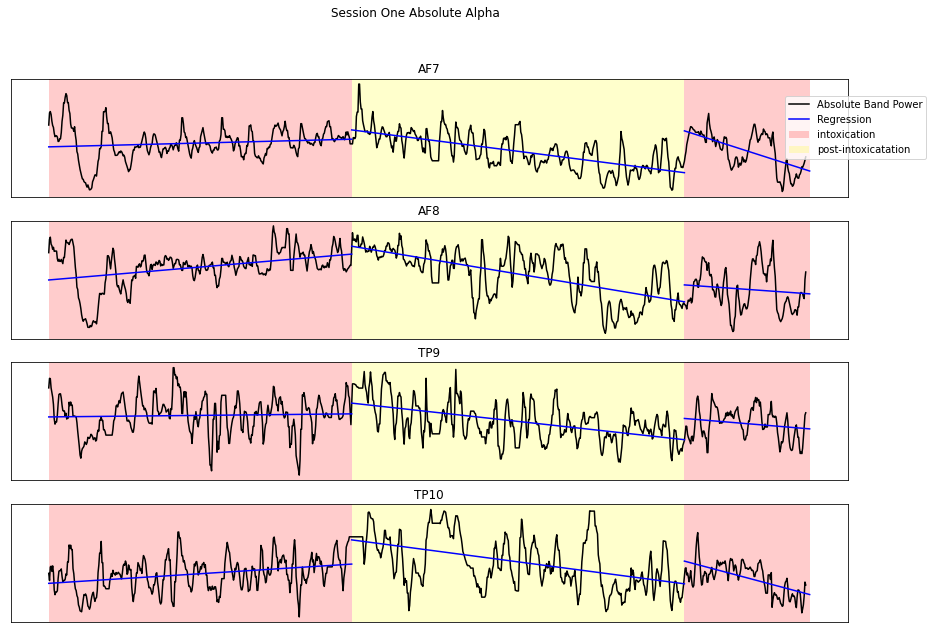

In [4]:
periods = [("red", "intoxication", intox1),
          ("yellow", "post-intoxicatation", sober1),
          ("red", "intoxication", intox2)]
brainwave_abs_plot(ses1, "Session One Absolute Alpha", periods, includeEndReg=False)

What we saw was a small increase in Alpha Waves during the first three-minute period of smoking, followed by a trend in decrease during the five minute period of sobriety, and finally by another session of smoking of one minute. If smoking leads to an increase in alpha frequency, this is the trend that we'd expect to see.

The second period of intoxication's sharp decline is attributable to the small window of time (8 minutes for the entire session), and did not have enough time to be effected by the nicotine because the nicotine did not act quick enough. 

Our interest then spread to the non-alpha waves, and see what possible potential other pattern exists. Perhaps a change in alpha impacts the other waves.

**NOTE**: the periods do not take into account the moving_avg, and therefor can be unrepresentative (albeit minor) of the values

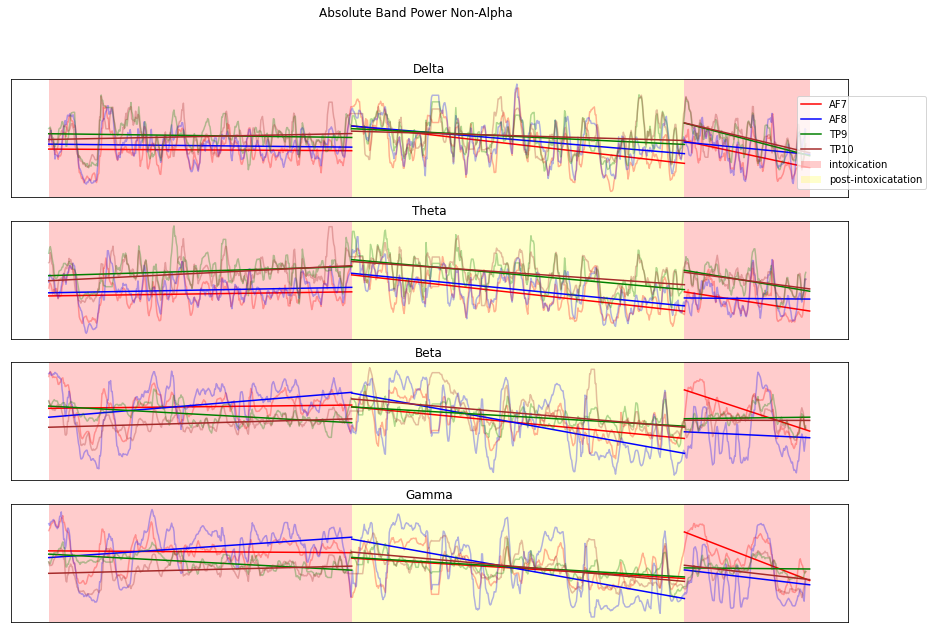

In [5]:
brainwave_nonalpha_plot(ses1, "Absolute Band Power Non-Alpha", periods)

We find that the non-alpha waves mimic the increase and decrease patterns found in the alpha band power, implying an unknown confounding factor is at play such that the alpha waves are following a general trend rather than being directly impacted by the nicotine. One way to confirm this confounding factor is to normalize alpha. If we change the absolute to relative band power (a normalized form) via the [equation](https://web.archive.org/web/20181105231756/http://developer.choosemuse.com/tools/available-data#Relative_Band_Powers):
$$\text{relative_alpha} = \frac{10^\alpha}{\sum_{i=\alpha, \beta,\delta,\gamma,\theta}10^i}$$
we hopefully are still able to visualize this change in proportionality in alpha. The power 10 is because the absolute band power is under a logarithm.

If Alpha Frequency is truely effected, we should see that the Alpha frequency have a higher increase in compared all the other waves, or a positive coefficient in the relative alpha.

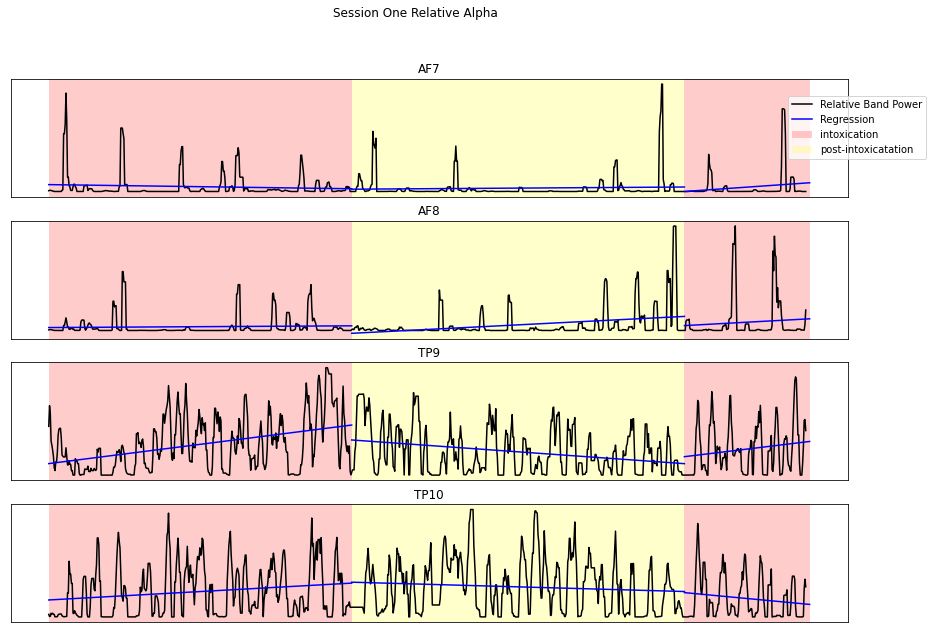

In [6]:
brainwave_rel_plot(ses1, "Session One Relative Alpha", periods, includeEndReg=False)

We do see the trend we are looking for strongly in the TP sensors. The AF sensors appears to have similar results, but they are not as strongly represented compared to TP. We believe this is consistent with the hypothesis that smoking increases alpha waves. We will procceed to other the sessions and hopefully the other sessions will also have the signal we are looking for.

#### Session Two

|time|action|
|-|-|
|0:00-6:36| normal breathing focusing on nothing|
|6:36-6:40| stressful thought|
|6:45-7:00| writing|
|8:45-9:15| focussed on clock|
|9:15-9:30| writing|
|9:30-10:25| normal breathing focusing on nothing|
|10:25| picked up vape and inhaled|
|10:45| picked up vape and inhaled (swallowed)|
|11:25| picked up vape and inhaled|
|11:45| picked up vape and inhaled (swallowed)|
|11:45-15:00| Continued to vape every minute until 15:00|
|15:00-20:00| normal breathing focusing on nothing|
|20:00| end writing|

|external variable| description|
|-|-|
|Setting| In my living room, sitting at my desk|
|Ambient noise| Birds chirping
|Vape used| Smok Novo X at 24watts|
|Salt Nicotine used|  50mg Apple by Reds|

We decided to alter the session to be in a sober-smoking-sober pattern such that we have a better control. The sober period will not be effected by the smoking. The post-smoking sober session is there in case the delayed nicotine effects comes into play.

We will be conducting the same visual tests from session one, but without the absolute non-alpha graph as the relative alpha provides a similar and cleaner presentation.

In [7]:
ses2 = pd.read_csv(session_two_fp, parse_dates=["TimeStamp"])

# Time Markers
m1 = ses2.TimeStamp[0]
m2 = ses2.TimeStamp[0] + timedelta(seconds=60 * 10 + 25)
m3 = ses2.TimeStamp[0] + timedelta(seconds=60*15)
m4 = ses2.TimeStamp.iloc[-1]

sober1 = [sum(ses2.TimeStamp < m1), sum(ses2.TimeStamp < m2)]
intox1 = [sum(ses2.TimeStamp < m2), sum(ses2.TimeStamp < m3)]
sober2 = [sum(ses2.TimeStamp < m3), sum(ses2.TimeStamp < m4)]

# For logistic mdl
ses2_X1 = ses2[ses2.TimeStamp < m2]
ses2_X2 = ses2[(ses2.TimeStamp < m3) & (ses2.TimeStamp > m2)]
ses2_X3 = ses2[(ses2.TimeStamp < m4) & (ses2.TimeStamp > m2)] # intox+post_intoxc:146] Creating new thread pool with default inter op setting: 2. Tune

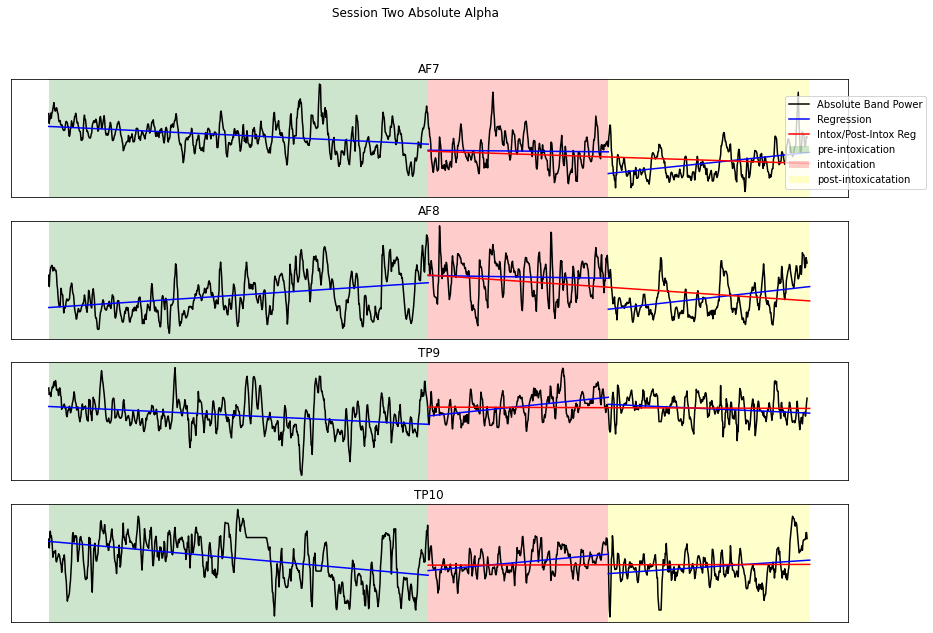

In [8]:
periods = [("green", "pre-intoxication", sober1),
           ("red", "intoxication", intox1),
           ("yellow", "post-intoxicatation", sober2)
          ]
brainwave_abs_plot(ses2, "Session Two Absolute Alpha", periods)

Again, the signal appears strongest in the TP sensors. We see that increase in alpha waves during the smoking period, and post-intoxication. We'd expect to see a relatively stable sober period, since this is the "clean slate," but the coefficients affliated with these periods demonstrate a general decrease in alpha.

The AF sensors however, do not really reflect our that increase in alpha. During the post intoxication period, we saw a rapid decrease in alpha waves that had a slow increase near the end. AF7 in particular, actually shows a decrease in alpha.

The relative-alpha graph should be the deciding factor of whether our findings are indeed affected by the nicotine.

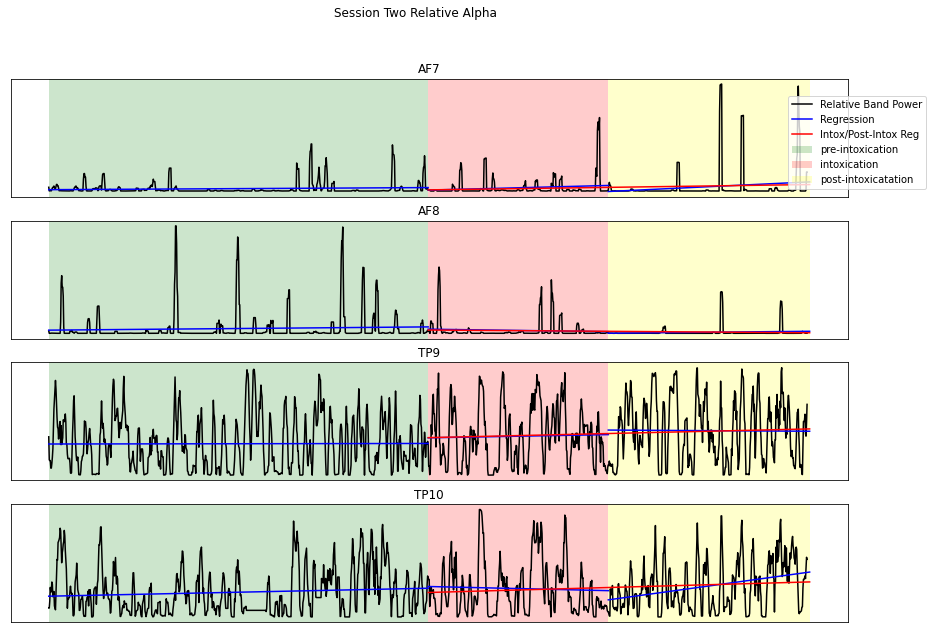

In [9]:
brainwave_rel_plot(ses2, "Session Two Relative Alpha", periods)

We see a slight positive cofficient in the post-intox periods, which could mean that the nicotine is taking effect not during the smoking, but shortly after. An important feature of the regression to take into account also is the bias term. We see that the bias term in TP9 taking almost a step pattern, showing that there is an increase in alpha frequency after smoking. In addition, AF7 does demonstrate the values are increasing at a much higher rate compared to the other waves. Only AF8 appears to have a decrease in alpha.

### Session Three

|time|action|
|-|-|
|12:18-12:21| no nic|
|12:21-12:24| nic|
|12:24-12:27| no nic|

|external variable| description|
|-|-|
|Setting| Sitting at a chair, minimal movement, consistent and similar intervals of breath|
|Vape| Puff Bar Liche Ice|

Due to the success of session two, we kept most of the traits into the third session. The only diffence was that we wanted to have consistency in our periods, so each period should have the same time. According to Frederick, he felt the effects of niccotine most strongly in session three. 

In [10]:
ses3 = pd.read_csv(session_three_fp, parse_dates=["TimeStamp"])

# Time Markers
m1 = ses2.TimeStamp[0]
m2 = datetime(2021,3,3,12,21)
m3 = datetime(2021,3,3,12,24)
m4 = datetime(2021,3,3,12,27)

# Periods
sober1 = [sum(ses3.TimeStamp < m1), sum(ses3.TimeStamp < m2)]
intox1 = [sum(ses3.TimeStamp < m2), sum(ses3.TimeStamp < m3)]
sober2 = [sum(ses3.TimeStamp < m3), sum(ses3.TimeStamp < m4)]

# For logistic mdl
ses3_X1 =  ses3[ses3.TimeStamp < m2] # sober
ses3_X2 =  ses3[(ses3.TimeStamp < m3) & (ses3.TimeStamp > m2)] # intox
ses3_X3 = ses3[(ses3.TimeStamp < m4) & (ses3.TimeStamp > m2)] # intox+post_intox

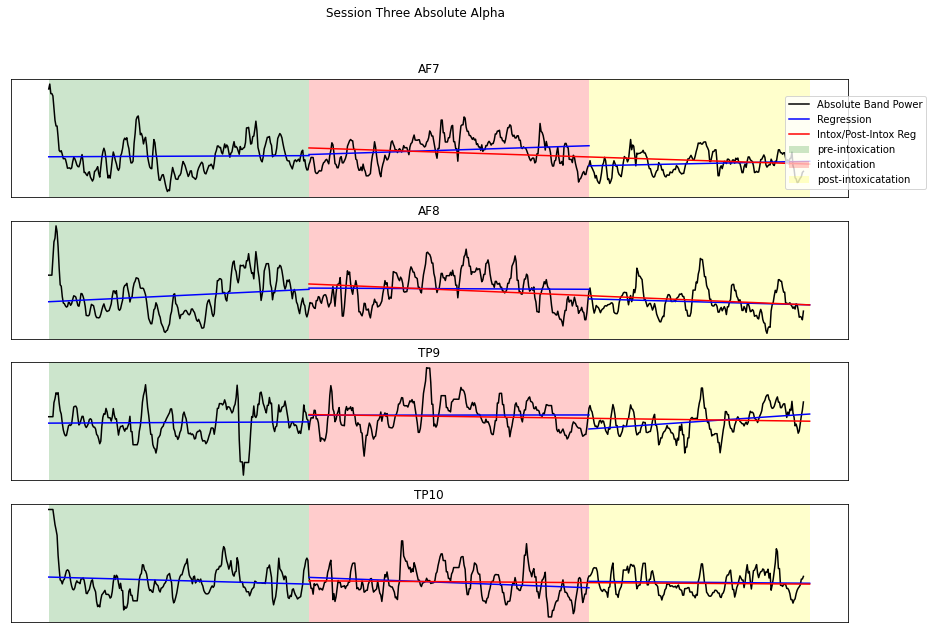

In [11]:
periods = [("green", "pre-intoxication", sober1),
           ("red", "intoxication", intox1),
           ("yellow", "post-intoxicatation", sober2),
          ]
brainwave_abs_plot(ses3, "Session Three Absolute Alpha", periods)

The waves are a lot more stable comparative to the previous two sessions. It actually appears that the nicotine had little effect.

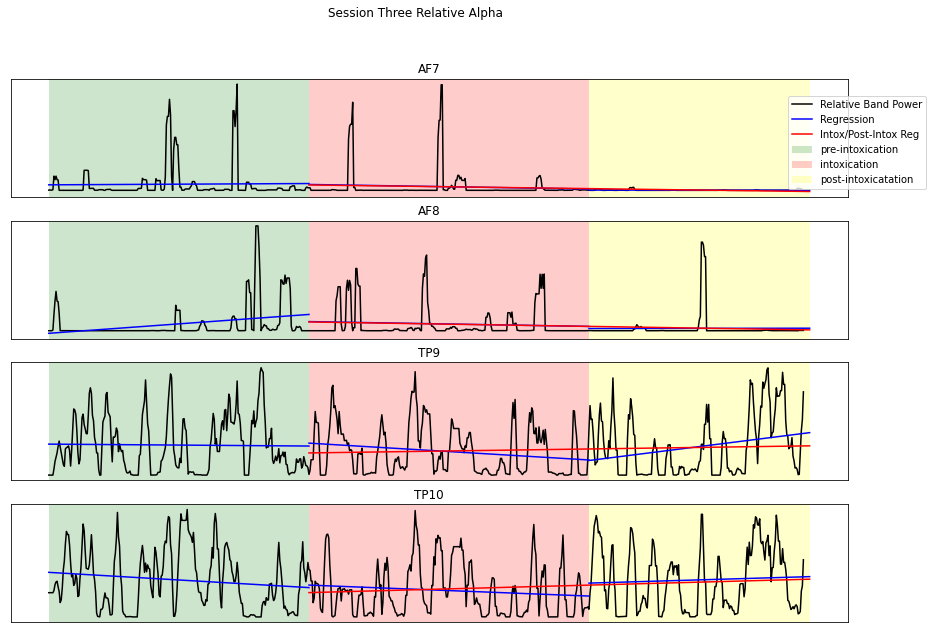

In [12]:
brainwave_rel_plot(ses3, "Session Three Relative Alpha", periods)

We see a general decrease in the relative alpha band power during intoxication across all four sensors when intoxicated, which is follows the direction of. It is the opposite of what we expect. In addition AF7 appears to be on a decline continuously with the second sober period having almost no activity.

### Session Four
|time|action|
|-|-|
|0-5| no nic|
|5-10| nic|
|10-15| no nic|

We increased the sampling rate for session four from 1Hz to ~220 Hz. This allows us to use the raw EEG in our EEGNet. Our moving average batch is increased to take into account this increase in frequency.

In [13]:
ses4 = pd.read_csv(session_four_fp, parse_dates=["TimeStamp"])

# Time Markers
m1 = ses4.TimeStamp[0]
m2 = ses4.TimeStamp[0] + timedelta(seconds=60*5)
m3 = ses4.TimeStamp[0] + timedelta(seconds=60*10)
m4 = ses4.TimeStamp.iloc[-1]

# Period
sober1 = [sum(ses4.TimeStamp < m1), sum(ses4.TimeStamp < m2)]
intox1 = [sum(ses4.TimeStamp < m2), sum(ses4.TimeStamp < m3)]
sober2 = [sum(ses4.TimeStamp < m3), sum(ses4.TimeStamp < m4)]

# Data for EEGNet
ses4_timestamps = [m1, m2 , m3, m4]

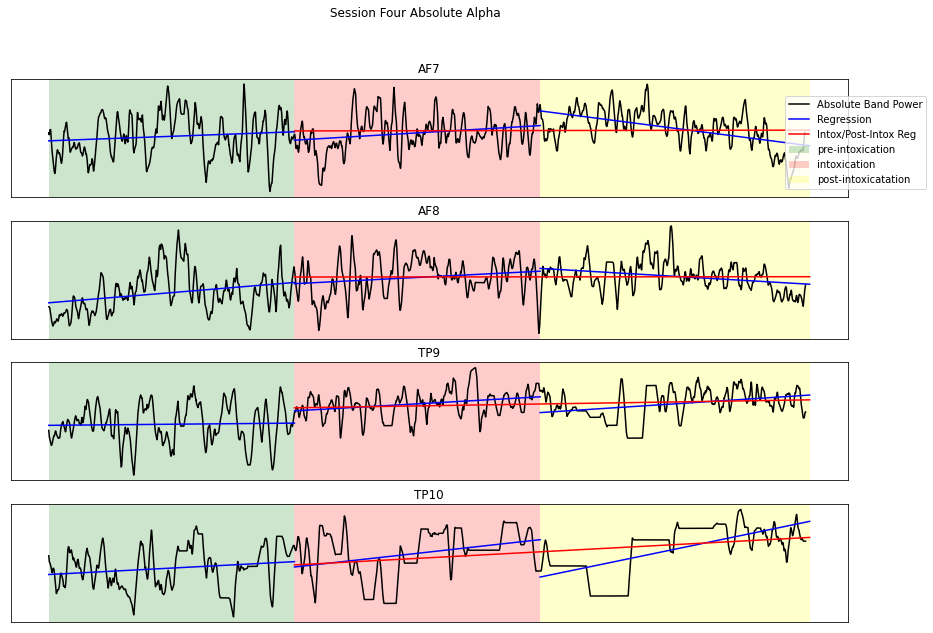

In [14]:
periods = [("green", "pre-intoxication", sober1),
           ("red", "intoxication", intox1),
           ("yellow", "post-intoxicatation", sober2),
          ]
brainwave_abs_plot(ses4, "Session Four Absolute Alpha", periods, BATCH=BATCH*220)

There appears to be a lot of data loss in TP10 in intox and post intox period. We do see the increase in alpha frequency during intoxication however and post intoxication.

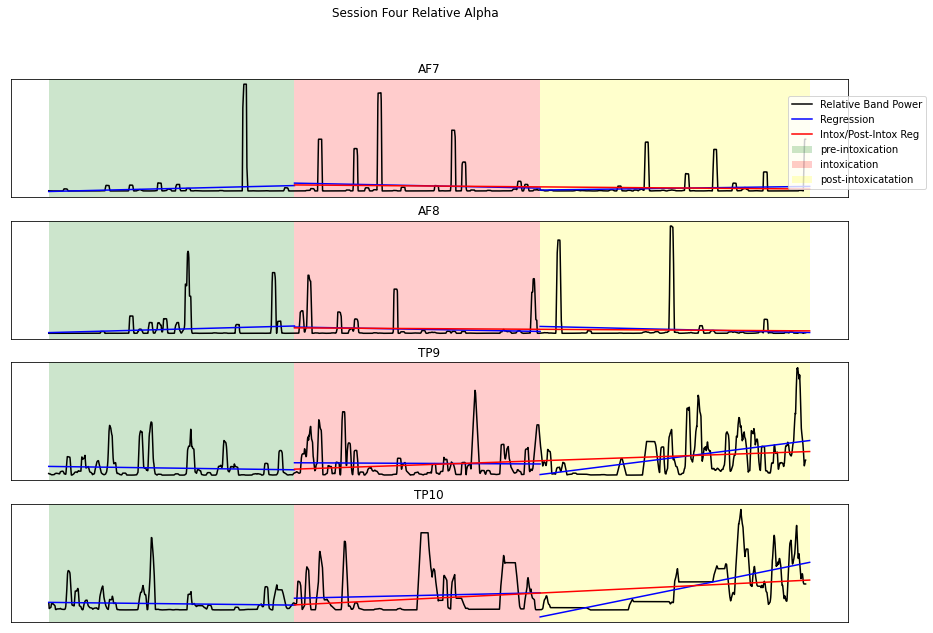

In [15]:
brainwave_rel_plot(ses4, "Session Four Relative Alpha", periods, BATCH=BATCH*220)

Similar to session two, it is difficult to see the signal in the relative band power for AF sensors. The regression coefficients are near zero during the intox period so it is difficult to make a concluding decision. 

The TP sensors demonstrate that increase in alpha however.

### Data Analysis Overview

The general trend that we saw was an increase in alpha waves when taking into account the intox and post-intox period for the TP sensors.

If we were to isolate the decision to only the intox and pre-intox period or include the AF sensors, our findings appear inconclusive. We think this is due to the delayed effect of nicotine on the brain waves, and certain sensors having a stronger ability to pick up the effect.

Session one should not be used as it was not consistent in the period cycle compared to the other three sessions, and session three appears to have zero signal. Session two, and session four does show some intriguing values, but thats only if we take into account only the TP sensors. This feels and approaches "cherry picking" our data however.

Conclusively, there is a weak indication that Alpha waves increase when intoxicated. 

## Modeling Analysis

Theres a common misconception that the sole purpose of models is for functional tasks, i.e. the output is the only thing important; however, models can also be used as an analytics tool. We shall be performing model analytics on a logistic classifier algorithm. We expect that the analysis should reveal similar results as the visualization analysis we just completed.

## Logistic Regression Classifier

There are an inifinite number of ways to parameterize a logistic regression classifier. However, as we are looking for understanding rather then accuracy, there must some interpretation to the parametrics. Initially, we believe a good way to parametize the logistic regression is to take into account five seconds of the graph. To do such, we'll be taking into consideration all the band powers on all four sensors. Therefor the number of parameters should be $\text{num_sensors} * \text{num_waves} * \text{num_rows or time} + 1=101$ taking into the account the bias term. 

However, one of the biggest problems is the curse of dimensionality. There are approximately 101 parameters and the amount of data is most likely not enough. The data appears to be mostly noise based on the visual inspections done. The model would most likely have extremely high variance, however given more data, this analysis should give better insight on what happens during a nicotine high. 

We'll be session two, and three using only the pre-intox and intox period to demonstrate that the data was inconclusive if we were to take into account only those features. In addition, we shall be using frontfill to deal with smoothing nan values instead of moving average.

In [16]:
def conversion_X(X:pd.DataFrame, seconds:int, feature_space:list) -> np.array:
    """
    @param X: contains 2 dimensional features
    @param seconds: the number of seconds to take into account
    @param feature_space: features from X to take account into
    
    combines temporal row data to contain temporal aspects by converting all of them features
    """
    shape = X[feature_space].shape
    col = shape[1] * seconds
    clip = -((shape[0] * shape[1]) % col // shape[1])
    row = (shape[0] * shape[1]) // col
    if clip == 0:
        return np.array(X[feature_space].fillna(method='ffill')).reshape(row, col)
    return np.array(X[feature_space].fillna(method='ffill')[:clip]).reshape(row, col)

def coefficient_plot(data,
                     y_data,
                     feature_space,
                     time_seq=5,
                     titleName='',
                     idx=['Delta', 'Theta', "Alpha", "Beta", "Gamma"], 
                     cols=["TP9", "AF7", "AF8", "TP10"]):
    """
    Creates a coeffiecient visual
    """
    # Data Preperation
    convertedX = [conversion_X(x, time_seq, feature_space) for x in data]
    X = np.concatenate(convertedX)

    # Let y=-1 be sober, y=1 be intox
    y_val = [np.ones(len(x)) * state for x, state in zip(convertedX, y_data)]
    y = np.concatenate(y_val)

    # Model Development
    mdl = linear_model.LogisticRegression(fit_intercept=True)
    mdl.fit(X, y)
    coef_matrix, bias = mdl.coef_.reshape(time_seq, len(idx), len(cols)), mdl.intercept_[0] # coef-time, brainwaves, sensors. 

    dfs = [pd.DataFrame(time, 
                       index=idx, 
                       columns=cols)
        for time in coef_matrix]
    fig, ax = plt.subplots(1, time_seq, figsize=(15, 10))
    for i, df in enumerate(dfs):
        ax[i].imshow(df)
        ax[i].set_title(f"Time: {i + 1}")
        ax[i].set_yticks(np.arange(len(idx)))
        ax[i].set_xticks(np.arange(len(cols)))
        ax[i].set_yticklabels(idx, rotation=90)
        ax[i].set_xticklabels(cols)

        for j in range(len(idx)):
            for k in range(len(cols)):
                ax[i].text(k, j, round(df.iloc[j, k], 2), ha="center", va="center", color="w")
    plt.suptitle(titleName, y=.75)
    plt.show()

## PreIntox + Intox
We'll be covering the analysis on the preintox and intox period, ignoring the post intox data.

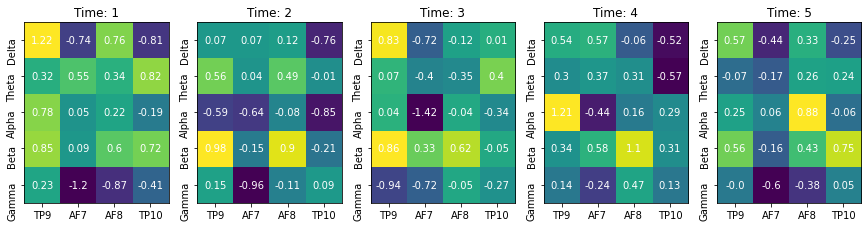

In [17]:
data = [ses2_X1, ses2_X2, ses3_X1, ses3_X2]
y_data = [-1, 1, -1, 1, -1]
feature_space = ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
                'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 
                'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 
                'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 
                'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10']
idx = ['Delta', 'Theta', "Alpha", "Beta", "Gamma"]
cols = ["TP9", "AF7", "AF8", "TP10"]
coefficient_plot(data, y_data, feature_space, idx=idx, cols=cols) 

Focusing on the Alpha waves, there does not appear to be any distinct pattern in the coefficients. If we were expecting an increase in alpha waves, then the expected coefficients on Alpha should have all been positive with the coefficients increasing as time progresses, as then they would be attributable to the intox period.

When we went to office hours, Professor de Sa recommended removing the Gamma waves. As such, we replicate the classifier, this time without the Gamma waves. We will also isolate the left and right side sensors in a later classifier, again recommended by Professor de Sa. The coefficients on the left and right do appear to have a strong spearman correlation on the respective sensors

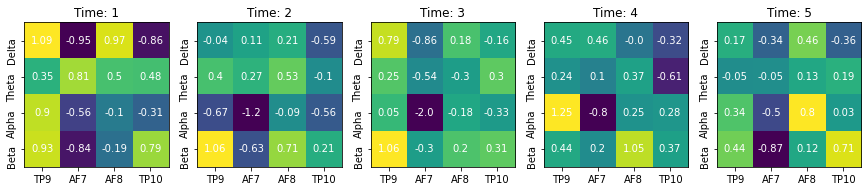

In [18]:
feature_space= ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
                'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 
                'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 
                'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10']
idx = ['Delta', 'Theta', "Alpha", "Beta"]
cols = ["TP9", "AF7", "AF8", "TP10"]
coefficient_plot(data, y_data, feature_space, idx=idx, cols=cols) 

The bias term is lower, but at the same time, the alpha wave coeficients do not hold any intriguing information and pairing sensors. The next step will be the left and right side isolation. As mentioned briefly in the beginning, these sensors correspond to the following:
* AF7: Left Forehead (dependent on headsize)
* AF8: Right Forehead (dependent on headsize)
* TP9: Left Ear
* TP10: Right Ear

The left-right sets will be {AF7, TP9}, {AF8, TP10}.

The paired sets are {AF7, AF8}, {TP9, TP10}.

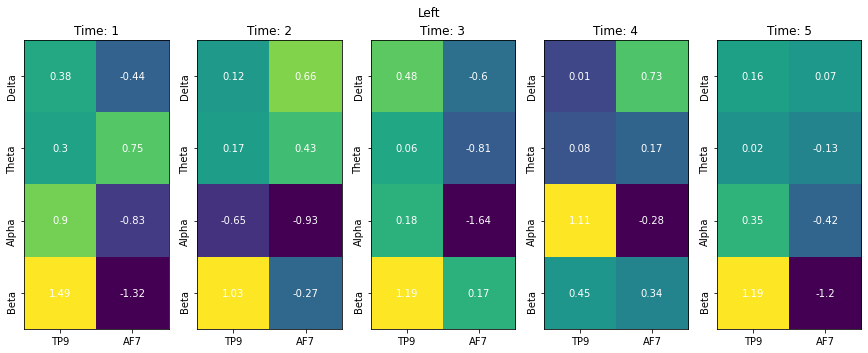

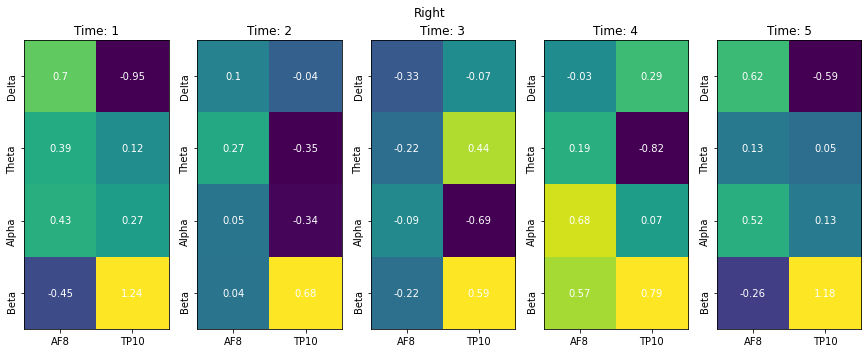

In [19]:
### LEFT
feature_space= ['Delta_TP9', 'Delta_AF7',
                'Theta_TP9', 'Theta_AF7', 
                'Alpha_TP9', 'Alpha_AF7', 
                'Beta_TP9', 'Beta_AF7', ]
idx = ['Delta', 'Theta', "Alpha", "Beta"]
cols = ["TP9", "AF7"]
coefficient_plot(data, y_data, feature_space, idx=idx, cols=cols, titleName="Left") 

### RIGHT
feature_space= ['Delta_AF8', 'Delta_TP10',
                'Theta_AF8', 'Theta_TP10', 
                'Alpha_AF8', 'Alpha_TP10', 
                'Beta_AF8', 'Beta_TP10']
idx = ['Delta', 'Theta', "Alpha", "Beta"]
cols = ["AF8", "TP10"]
coefficient_plot(data, y_data, feature_space, idx=idx, cols=cols, titleName="Right") 

Left side analysis does produce some possible strong positive coefficients affliating alpha with intox. There are negative coefficients corresponding to Time=1,TP9,Alpha and Time=4,TP9,Alpha but AF7 has all positive coefficients.

Right side analysis demonstrates some relation with TP10 and an increase in alpha waves, however AF8 indicates a negative relation. Results are inconclusive.

Lets look at the pairs now.

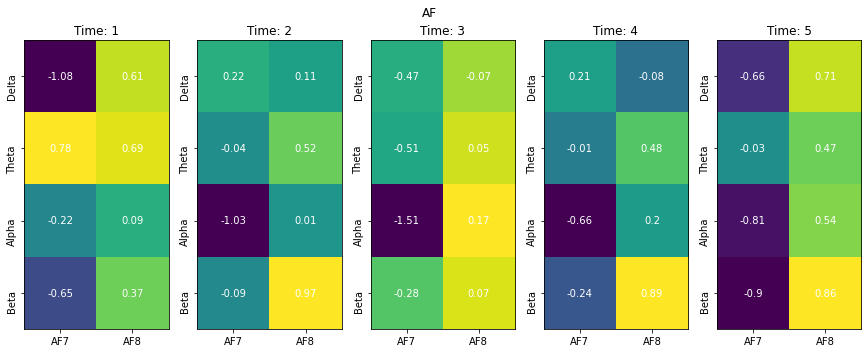

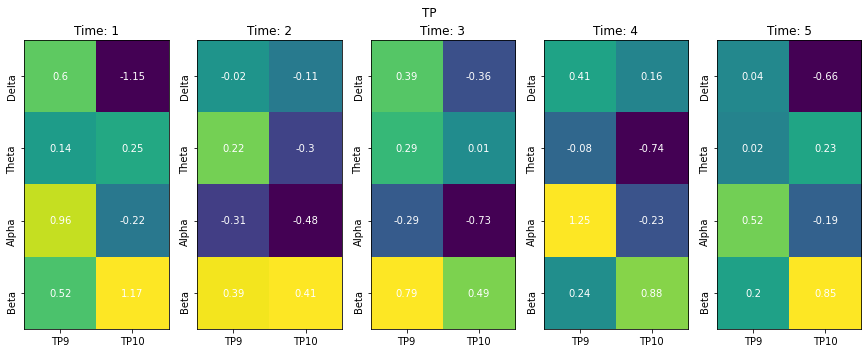

In [20]:
#### AF
feature_space= ['Delta_AF7', 'Delta_AF8',
                'Theta_AF7', 'Theta_AF8', 
                'Alpha_AF7', 'Alpha_AF8', 
                'Beta_AF7', 'Beta_AF8']
idx = ['Delta', 'Theta', "Alpha", "Beta"]
cols = ["AF7", "AF8"]
coefficient_plot(data, y_data, feature_space, idx=idx, cols=cols, titleName="AF") 

#### TP
feature_space= ['Delta_TP9', 'Delta_TP10',
                'Theta_TP9', 'Theta_TP10', 
                'Alpha_TP9', 'Alpha_TP10', 
                'Beta_TP9', 'Beta_TP10']
idx = ['Delta', 'Theta', "Alpha", "Beta"]
cols = ["TP9", "TP10"]
coefficient_plot(data, y_data, feature_space, idx=idx, cols=cols, titleName="TP")

### PreIntox + Intox Overview
We see that the coefficient analysis did not demonstrate any coherent findings. The next step is to utilize this same information but include the post-intox information also.

## PreIntox  + Intox/PostIntox
Now we will be doing the same analysis but with including all information

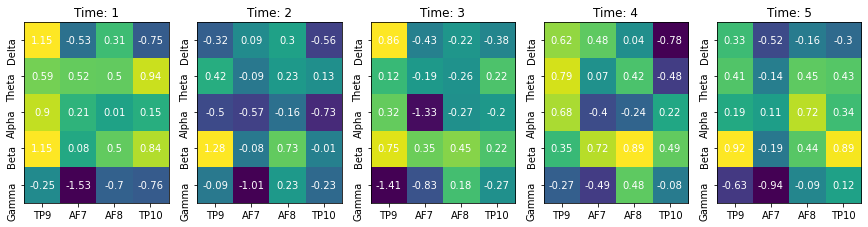

In [29]:
data = [ses2_X1, ses2_X3, ses3_X1, ses3_X3]
y_data = [-1, 1, -1, 1, -1]
feature_space = ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
                'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 
                'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 
                'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 
                'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10']
idx = ['Delta', 'Theta', "Alpha", "Beta", "Gamma"]
cols = ["TP9", "AF7", "AF8", "TP10"]
coefficient_plot(data, y_data, feature_space, idx=idx, cols=cols)

The alpha coefficients are more positive compared to the intox only data points, indicating that the post intox information is contributable to the signal.

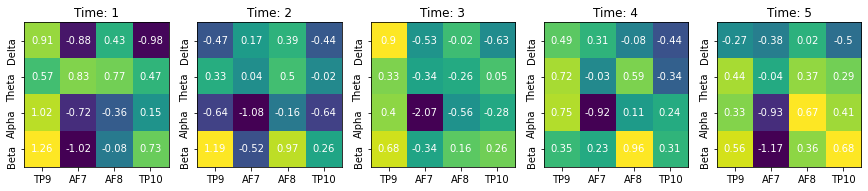

In [26]:
feature_space= ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
                'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 
                'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 
                'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10']
idx = ['Delta', 'Theta', "Alpha", "Beta"]
cols = ["TP9", "AF7", "AF8", "TP10"]
coefficient_plot(data, y_data, feature_space, idx=idx, cols=cols) 

The AF7 sensor has a strong negative relation to Alpha, which means that a large Alpha in AF7 contributes to the model thinking the person is sober. The other sensors tend to be positive, which again, shows some signal indicating that a positive that smoking does increase Alpha waves.

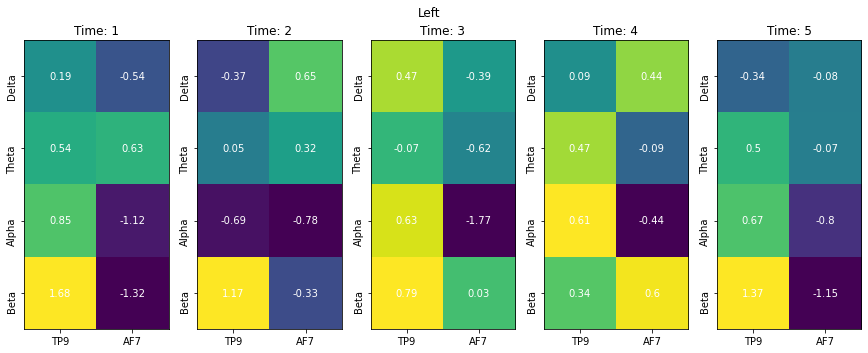

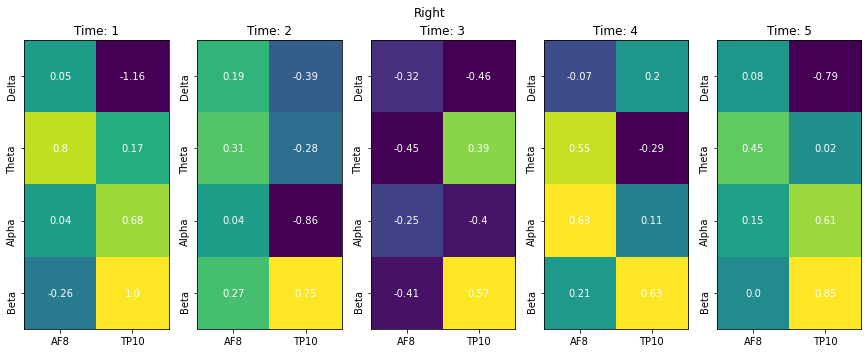

In [27]:
### LEFT
feature_space= ['Delta_TP9', 'Delta_AF7',
                'Theta_TP9', 'Theta_AF7', 
                'Alpha_TP9', 'Alpha_AF7', 
                'Beta_TP9', 'Beta_AF7', ]
idx = ['Delta', 'Theta', "Alpha", "Beta"]
cols = ["TP9", "AF7"]
coefficient_plot(data, y_data, feature_space, idx=idx, cols=cols, titleName="Left") 

### RIGHT
feature_space= ['Delta_AF8', 'Delta_TP10',
                'Theta_AF8', 'Theta_TP10', 
                'Alpha_AF8', 'Alpha_TP10', 
                'Beta_AF8', 'Beta_TP10']
idx = ['Delta', 'Theta', "Alpha", "Beta"]
cols = ["AF8", "TP10"]
coefficient_plot(data, y_data, feature_space, idx=idx, cols=cols, titleName="Right") 

Isolating the left and right appears to not have much indicaton of which side is the stronger classifier.

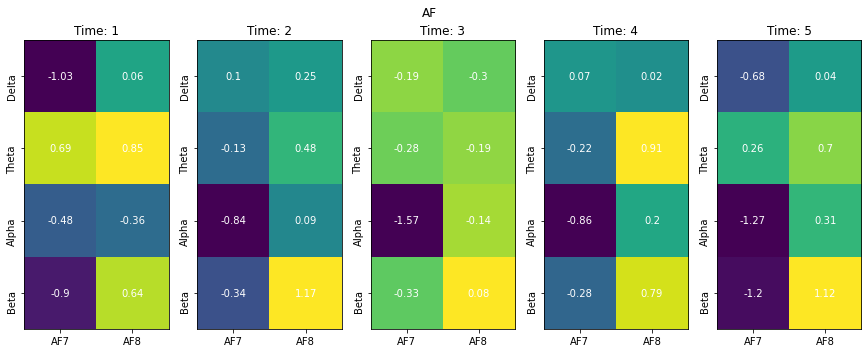

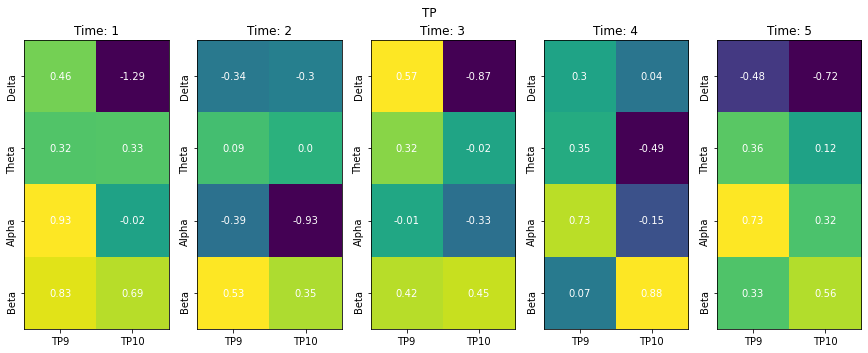

In [30]:
#### AF
feature_space= ['Delta_AF7', 'Delta_AF8',
                'Theta_AF7', 'Theta_AF8', 
                'Alpha_AF7', 'Alpha_AF8', 
                'Beta_AF7', 'Beta_AF8']
idx = ['Delta', 'Theta', "Alpha", "Beta"]
cols = ["AF7", "AF8"]
coefficient_plot(data, y_data, feature_space, idx=idx, cols=cols, titleName="AF") 

#### TP
feature_space= ['Delta_TP9', 'Delta_TP10',
                'Theta_TP9', 'Theta_TP10', 
                'Alpha_TP9', 'Alpha_TP10', 
                'Beta_TP9', 'Beta_TP10']
idx = ['Delta', 'Theta', "Alpha", "Beta"]
cols = ["TP9", "TP10"]
coefficient_plot(data, y_data, feature_space, idx=idx, cols=cols, titleName="TP")

In addition, isolating the TP and AD sensors appear to be detrimental to the classifer strength as the coefficients appear to not follow a pattern. Both the Left/Right and AF/TP isolation models indicate that by themselves, the alpha waves is not a strong indicators, but combining the sensors creates does create a stronger reliance on alpha. 

# IV) Results
Overall, our analysis was split into two portions. One where we looked directly at the data, and another indirectly through looking at model coefficients. In both, we found that the results were mostly inconclusive with the specifications imbedded in the methodology section.

While we did see a small trend indicating that Alpha waves increased after smoking, a lot of this information could only be found through non random selection of the data. 

### Problems
There were several problems that we did overcome. Specifically, the data collection process had some major problems and we were unsure whether the problem lied with us, or the Muse. A lot of the problems can also be boiled down to starting the the analysis while in the process of research. We had a cycle of doing a session, analyzing it and seeing that it didn't have any signal, and trying to alter what we did during the data collection to hopefully garner better data.

This could be seen in session one, where we did not plan out what the session would be like, with only a vague idea of what direction we wanted to head. As we did further research, we were inspired by some of the findings and methodologies and decided to go the route that we did, and evolved the experiment as we garnered more experience.

Our code also went through several major rewrites to fit the changing sessions and to better generalize the process. This took up a lot of time that could have been used better for research. This is actually one of the major reasons why we did not include session four in the model coefficient analysis, since this would require another code rewrite that we unfortunately ran out of time for.

We also removed a portion of the model analysis, where we wanted to analyze an EEGNet. We read the paper and downloaded the code the author's used and retrofitted our data onto the paper. Unfortunately, we were unable to train the EEGNet as it returned nan values with the data. We decided to discard the analysis despite spending several hours on cleaning the data to fit the EEGNet criteria, and research.

# V) Discussion

Despite the inconclusive result, we believe we learned a lot through the difficulties we encountered: BCI analysis requires sifting through heavily noisy data and Muse Headbands suck.


What studies would you suggest to do next? -> better data collection. Would want longer periods, controlled external factors, and more people involved.
What is your opinion of the strengths and weaknesses of the algorithm/idea(s). -> should be include a general trend. have coefficients as part of the feature space

In [ ]:
Ana